In [2]:
import numpy as np          
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd       
import seaborn as sns       
import sklearn   
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# 0 Описание задачи
Обучить на данных полносвязную (неглубокую) нейронную сеть. Попробовать 1-2 скрытых слоя. Построить графики зависимости ошибки на обучающей выборке и тестовой выборках от параметра alpha и от количества нейронов. Наблюдается ли переобучение/недообучение? 
# 1 Чтение данных

In [3]:
url = 'https://github.com/bakaevam/machine-learning-course-2021/raw/main/music_genre.csv'
data = pd.read_csv(url, sep = ',', skipinitialspace = True)
data.shape

(17996, 17)

Уберем имя трека, избавимся от категориального признака, обработаем пропущенные значения проведем нормализацию

In [4]:
data = data.drop (['Track Name'], axis=1) 

In [10]:
object_cols = data.select_dtypes("object").columns
for col in object_cols:
    data = pd.concat((data, pd.get_dummies(data[col])), axis=1)
    data = data.drop([col], axis=1)
data.head()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,◊ï◊ô◊™◊®◊™◊ô,◊ò◊ú ◊ê◊ï◊®◊ü,◊ó◊†◊ü ◊ë◊ü ◊ê◊®◊ô,◊ô◊ï◊¶◊®◊ï◊™ ◊ê◊™ ◊î◊ë◊ï◊ù,◊ô◊ï◊í◊ë ◊í◊ú◊ï◊°◊û◊ü,◊ú◊ô◊ú ◊ê◊® ◊§◊ô ◊í'◊ô,◊û◊ê◊ô◊õ◊ï,◊û◊ô◊†◊ï◊° ◊ê◊§◊°,◊û◊õ◊ú◊ï◊£,◊†◊ê◊ì◊î
0,60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,...,0,0,0,0,0,0,0,0,0,0
1,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,...,0,0,0,0,0,0,0,0,0,0
2,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,...,0,0,0,0,0,0,0,0,0,0
3,66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,...,0,0,0,0,0,0,0,0,0,0
4,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,...,0,0,0,0,0,0,0,0,0,0


In [11]:
data.median(axis = 0)
data = data.fillna(data.median(axis = 0), axis = 0)
data.isna().sum()

Popularity                0
danceability              0
energy                    0
key                       0
loudness                  0
                         ..
◊ú◊ô◊ú ◊ê◊® ◊§◊ô ◊í'◊ô    0
◊û◊ê◊ô◊õ◊ï                0
◊û◊ô◊†◊ï◊° ◊ê◊§◊°         0
◊û◊õ◊ú◊ï◊£                0
◊†◊ê◊ì◊î                  0
Length: 9164, dtype: int64

In [13]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(0, 2))

data_columns = data.columns
d = scaler.fit_transform(data)

scaled_df = pd.DataFrame(d, columns=data_columns)

scaled_df.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,◊ï◊ô◊™◊®◊™◊ô,◊ò◊ú ◊ê◊ï◊®◊ü,◊ó◊†◊ü ◊ë◊ü ◊ê◊®◊ô,◊ô◊ï◊¶◊®◊ï◊™ ◊ê◊™ ◊î◊ë◊ï◊ù,◊ô◊ï◊í◊ë ◊í◊ú◊ï◊°◊û◊ü,◊ú◊ô◊ú ◊ê◊® ◊§◊ô ◊í'◊ô,◊û◊ê◊ô◊õ◊ï,◊û◊ô◊†◊ï◊° ◊ê◊§◊°,◊û◊õ◊ú◊ï◊£,◊†◊ê◊ì◊î
count,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,...,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000
mean,0.878787,1.041173,1.325540,0.991554,1.551376,1.273505,0.122696,0.496148,0.271738,0.372978,...,0.000111,0.000111,0.000111,0.000111,0.000111,0.000111,0.000222,0.000222,0.000111,0.000111
std,0.347851,0.357797,0.470756,0.602538,0.196052,0.961897,0.179252,0.623760,0.551791,0.322258,...,0.014909,0.014909,0.014909,0.014909,0.014909,0.014909,0.021084,0.021084,0.014909,0.014909
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.646465,0.801377,1.017980,0.600000,1.472583,0.000000,0.026381,0.008635,0.000588,0.173262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.868687,1.044545,1.399988,1.000000,1.594693,2.000000,0.053405,0.163454,0.007849,0.237021,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.111111,1.289864,1.719994,1.400000,1.683153,2.000000,0.129759,0.871486,0.113653,0.498128,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


# 2 Разбиение на обучающую и тестовую выборки
Сначала разобьем данные на обучающую 66% и тестовую 33% выборки

In [14]:
X = scaled_df.drop (['Class'], axis=1) 
y = data['Class']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(12057, 5939)

Подберем гиперпараметры

В качестве solver выберем алгоритм adam

В качестве функции активации выберем Relu

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

hidden_layer_size = np.linspace(1, 50, 50)
hidden_layer_size = hidden_layer_size.astype(int)
test_err, train_err = [], []
train_acc, test_acc = [], []

for size in tqdm(hidden_layer_size):
    model = MLPClassifier(hidden_layer_sizes=(size,), 
                          solver='adam', activation='relu', max_iter=1000, random_state=13)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\mary3\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 50/50 [12:40:39<00:00, 912.79s/it]   


Train: Min error=0.07987061458074148, number of neurons=42
Test: Min error=0.47516416905202896, number of neurons=37


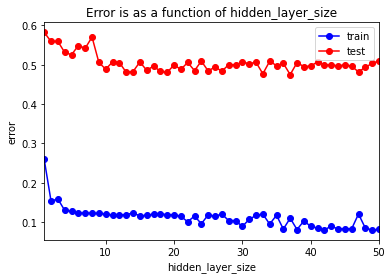

In [18]:
plt.plot(hidden_layer_size, train_err, 'b-o', label = 'train')
plt.plot(hidden_layer_size, test_err, 'r-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Error is as a function of hidden_layer_size')
plt.xlabel('hidden_layer_size')
plt.ylabel('error')
plt.legend()

print("Train: Min error={0}, number of neurons={1}".format(np.min(train_err), hidden_layer_size[np.argmin(train_err)]))
print("Test: Min error={0}, number of neurons={1}".format(np.min(test_err), hidden_layer_size[np.argmin(test_err)]))

Train: max accuracy=0.9201293854192585, number of neurons=42
Test: max accuracy=0.524835830947971, number of neurons=37


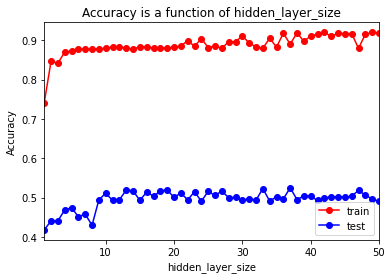

In [19]:
plt.plot(hidden_layer_size, train_acc, 'r-o', label = 'train')
plt.plot(hidden_layer_size, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Accuracy is a function of hidden_layer_size')
plt.xlabel('hidden_layer_size')
plt.ylabel('Accuracy')
plt.legend()

print("Train: max accuracy={0}, number of neurons={1}".format(np.max(train_acc), hidden_layer_size[np.argmax(train_acc)]))
print("Test: max accuracy={0}, number of neurons={1}".format(np.max(test_acc), hidden_layer_size[np.argmax(test_acc)]))

Наблюдается переобучение. Попробуем изменить количество обучающих и тестовых данных, параметры, алгоритм(sgd)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(15296, 2700)

In [23]:
hidden_layer_size = np.linspace(1, 40, 20)
hidden_layer_size = hidden_layer_size.astype(int)
test_err, train_err = [], []
train_acc, test_acc = [], []

for size in tqdm(hidden_layer_size):
    model = MLPClassifier(hidden_layer_sizes=(size,), 
                          solver='sgd', activation='relu', max_iter=1000, random_state=13, learning_rate_init=0.01, verbose = "True")
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

  0%|          | 0/20 [00:00<?, ?it/s]

Iteration 1, loss = 2.28298004
Iteration 2, loss = 2.12662927
Iteration 3, loss = 2.10124861
Iteration 4, loss = 2.08224606
Iteration 5, loss = 2.06491111
Iteration 6, loss = 2.04846876
Iteration 7, loss = 2.03332621
Iteration 8, loss = 2.01889646
Iteration 9, loss = 2.00496998
Iteration 10, loss = 1.99183992
Iteration 11, loss = 1.97954566
Iteration 12, loss = 1.96726784
Iteration 13, loss = 1.95573807
Iteration 14, loss = 1.94502995
Iteration 15, loss = 1.93425301
Iteration 16, loss = 1.92423960
Iteration 17, loss = 1.91439516
Iteration 18, loss = 1.90483886
Iteration 19, loss = 1.89587026
Iteration 20, loss = 1.88769506
Iteration 21, loss = 1.87983631
Iteration 22, loss = 1.87189478
Iteration 23, loss = 1.86451891
Iteration 24, loss = 1.85735795
Iteration 25, loss = 1.85061641
Iteration 26, loss = 1.84418714
Iteration 27, loss = 1.83782948
Iteration 28, loss = 1.83207427
Iteration 29, loss = 1.82573297
Iteration 30, loss = 1.82082588
Iteration 31, loss = 1.81462743
Iteration 32, los

Iteration 253, loss = 1.22588232
Iteration 254, loss = 1.22300550
Iteration 255, loss = 1.22293705
Iteration 256, loss = 1.22156743
Iteration 257, loss = 1.21976044
Iteration 258, loss = 1.21895739
Iteration 259, loss = 1.21823787
Iteration 260, loss = 1.21799206
Iteration 261, loss = 1.21485830
Iteration 262, loss = 1.21403323
Iteration 263, loss = 1.21347559
Iteration 264, loss = 1.21318367
Iteration 265, loss = 1.21237756
Iteration 266, loss = 1.21061307
Iteration 267, loss = 1.20970042
Iteration 268, loss = 1.20692869
Iteration 269, loss = 1.20590528
Iteration 270, loss = 1.20491823
Iteration 271, loss = 1.20445323
Iteration 272, loss = 1.20380962
Iteration 273, loss = 1.20147586
Iteration 274, loss = 1.20137686
Iteration 275, loss = 1.20012091
Iteration 276, loss = 1.19787177
Iteration 277, loss = 1.19971769
Iteration 278, loss = 1.19715570
Iteration 279, loss = 1.19527477
Iteration 280, loss = 1.19472611
Iteration 281, loss = 1.19514141
Iteration 282, loss = 1.19424055
Iteration 

  5%|▌         | 1/20 [23:39<7:29:27, 1419.36s/it]

Iteration 1, loss = 2.24878408
Iteration 2, loss = 2.03357239
Iteration 3, loss = 1.96722487
Iteration 4, loss = 1.91212259
Iteration 5, loss = 1.86550325
Iteration 6, loss = 1.82918022
Iteration 7, loss = 1.80263305
Iteration 8, loss = 1.78015953
Iteration 9, loss = 1.76214276
Iteration 10, loss = 1.74537716
Iteration 11, loss = 1.73033582
Iteration 12, loss = 1.71047609
Iteration 13, loss = 1.69169421
Iteration 14, loss = 1.67480558
Iteration 15, loss = 1.65982401
Iteration 16, loss = 1.64547985
Iteration 17, loss = 1.63110703
Iteration 18, loss = 1.61795902
Iteration 19, loss = 1.60563907
Iteration 20, loss = 1.59277084
Iteration 21, loss = 1.58050040
Iteration 22, loss = 1.56780603
Iteration 23, loss = 1.55660726
Iteration 24, loss = 1.54378604
Iteration 25, loss = 1.53127532
Iteration 26, loss = 1.51840473
Iteration 27, loss = 1.50667001
Iteration 28, loss = 1.49379965
Iteration 29, loss = 1.48175676
Iteration 30, loss = 1.46817395
Iteration 31, loss = 1.45592325
Iteration 32, los

Iteration 253, loss = 0.48446673
Iteration 254, loss = 0.47835297
Iteration 255, loss = 0.48158037
Iteration 256, loss = 0.47604074
Iteration 257, loss = 0.47862198
Iteration 258, loss = 0.48312982
Iteration 259, loss = 0.47270119
Iteration 260, loss = 0.46849147
Iteration 261, loss = 0.47356737
Iteration 262, loss = 0.47299511
Iteration 263, loss = 0.47321790
Iteration 264, loss = 0.47510727
Iteration 265, loss = 0.47277475
Iteration 266, loss = 0.46827452
Iteration 267, loss = 0.47502164
Iteration 268, loss = 0.47193946
Iteration 269, loss = 0.47059035
Iteration 270, loss = 0.46740081
Iteration 271, loss = 0.46769554
Iteration 272, loss = 0.46892654
Iteration 273, loss = 0.47103261
Iteration 274, loss = 0.46838524
Iteration 275, loss = 0.46933257
Iteration 276, loss = 0.47067465
Iteration 277, loss = 0.46594932
Iteration 278, loss = 0.46664469
Iteration 279, loss = 0.46150493
Iteration 280, loss = 0.46552745
Iteration 281, loss = 0.46354526
Iteration 282, loss = 0.46838950
Iteration 

 10%|█         | 2/20 [41:23<6:03:08, 1210.48s/it]

Iteration 1, loss = 2.22359233
Iteration 2, loss = 2.00296322
Iteration 3, loss = 1.93002251
Iteration 4, loss = 1.87317354
Iteration 5, loss = 1.83274111
Iteration 6, loss = 1.80087389
Iteration 7, loss = 1.77555182
Iteration 8, loss = 1.75374519
Iteration 9, loss = 1.73409016
Iteration 10, loss = 1.71598897
Iteration 11, loss = 1.69926834
Iteration 12, loss = 1.68308692
Iteration 13, loss = 1.66773096
Iteration 14, loss = 1.65173935
Iteration 15, loss = 1.63736329
Iteration 16, loss = 1.62272684
Iteration 17, loss = 1.60704495
Iteration 18, loss = 1.59194347
Iteration 19, loss = 1.57597096
Iteration 20, loss = 1.56198013
Iteration 21, loss = 1.54613656
Iteration 22, loss = 1.53087280
Iteration 23, loss = 1.51609398
Iteration 24, loss = 1.50156480
Iteration 25, loss = 1.48460029
Iteration 26, loss = 1.46908876
Iteration 27, loss = 1.45382644
Iteration 28, loss = 1.43917478
Iteration 29, loss = 1.42410373
Iteration 30, loss = 1.40861737
Iteration 31, loss = 1.39334587
Iteration 32, los

Iteration 253, loss = 0.49668599
Iteration 254, loss = 0.49745365
Iteration 255, loss = 0.50206738
Iteration 256, loss = 0.49596303
Iteration 257, loss = 0.49726671
Iteration 258, loss = 0.49326907
Iteration 259, loss = 0.49731206
Iteration 260, loss = 0.49160883
Iteration 261, loss = 0.49082384
Iteration 262, loss = 0.49488014
Iteration 263, loss = 0.49402577
Iteration 264, loss = 0.49162811
Iteration 265, loss = 0.49548690
Iteration 266, loss = 0.49283260
Iteration 267, loss = 0.49036017
Iteration 268, loss = 0.48786416
Iteration 269, loss = 0.48693800
Iteration 270, loss = 0.48519462
Iteration 271, loss = 0.48575668
Iteration 272, loss = 0.48676238
Iteration 273, loss = 0.48216285
Iteration 274, loss = 0.48202190
Iteration 275, loss = 0.48214095
Iteration 276, loss = 0.47656647
Iteration 277, loss = 0.48327516
Iteration 278, loss = 0.48171781
Iteration 279, loss = 0.48227964
Iteration 280, loss = 0.47665735
Iteration 281, loss = 0.47435187
Iteration 282, loss = 0.48268205
Iteration 

 15%|█▌        | 3/20 [58:54<5:22:22, 1137.82s/it]

Iteration 1, loss = 2.18055339
Iteration 2, loss = 1.99613615
Iteration 3, loss = 1.91230809
Iteration 4, loss = 1.84349133
Iteration 5, loss = 1.79164895
Iteration 6, loss = 1.75054014
Iteration 7, loss = 1.71629012
Iteration 8, loss = 1.68443229
Iteration 9, loss = 1.65450928
Iteration 10, loss = 1.62453730
Iteration 11, loss = 1.59387292
Iteration 12, loss = 1.56352454
Iteration 13, loss = 1.53376493
Iteration 14, loss = 1.50499731
Iteration 15, loss = 1.47755590
Iteration 16, loss = 1.45170329
Iteration 17, loss = 1.42511134
Iteration 18, loss = 1.39976248
Iteration 19, loss = 1.37595727
Iteration 20, loss = 1.35429624
Iteration 21, loss = 1.33082153
Iteration 22, loss = 1.30871402
Iteration 23, loss = 1.28875782
Iteration 24, loss = 1.26803547
Iteration 25, loss = 1.24814158
Iteration 26, loss = 1.22852347
Iteration 27, loss = 1.20929781
Iteration 28, loss = 1.19046224
Iteration 29, loss = 1.17310823
Iteration 30, loss = 1.15519875
Iteration 31, loss = 1.13724456
Iteration 32, los

Iteration 253, loss = 0.33596997
Iteration 254, loss = 0.34205709
Iteration 255, loss = 0.33584620
Iteration 256, loss = 0.33918577
Iteration 257, loss = 0.34072420
Iteration 258, loss = 0.33816581
Iteration 259, loss = 0.34034855
Iteration 260, loss = 0.33835421
Iteration 261, loss = 0.34161425
Iteration 262, loss = 0.33685583
Iteration 263, loss = 0.33755662
Iteration 264, loss = 0.33751338
Iteration 265, loss = 0.34179410
Iteration 266, loss = 0.33482201
Iteration 267, loss = 0.33097366
Iteration 268, loss = 0.33159677
Iteration 269, loss = 0.33180724
Iteration 270, loss = 0.33418902
Iteration 271, loss = 0.32962957
Iteration 272, loss = 0.33327860
Iteration 273, loss = 0.32767398
Iteration 274, loss = 0.33436593
Iteration 275, loss = 0.33675300
Iteration 276, loss = 0.33310582
Iteration 277, loss = 0.32882235
Iteration 278, loss = 0.33299756
Iteration 279, loss = 0.32832468
Iteration 280, loss = 0.32905169
Iteration 281, loss = 0.32823588
Iteration 282, loss = 0.32994012
Iteration 

 20%|██        | 4/20 [1:11:23<4:22:23, 983.98s/it]

Iteration 1, loss = 2.19983731
Iteration 2, loss = 1.95538547
Iteration 3, loss = 1.86828977
Iteration 4, loss = 1.79882365
Iteration 5, loss = 1.73311909
Iteration 6, loss = 1.67456354
Iteration 7, loss = 1.63018454
Iteration 8, loss = 1.59596105
Iteration 9, loss = 1.56849150
Iteration 10, loss = 1.54319115
Iteration 11, loss = 1.51900735
Iteration 12, loss = 1.49629781
Iteration 13, loss = 1.47479277
Iteration 14, loss = 1.45235819
Iteration 15, loss = 1.43236783
Iteration 16, loss = 1.41072771
Iteration 17, loss = 1.38886233
Iteration 18, loss = 1.36707667
Iteration 19, loss = 1.34703635
Iteration 20, loss = 1.32627823
Iteration 21, loss = 1.30522930
Iteration 22, loss = 1.28505027
Iteration 23, loss = 1.26343554
Iteration 24, loss = 1.24434668
Iteration 25, loss = 1.22419760
Iteration 26, loss = 1.20506799
Iteration 27, loss = 1.18556915
Iteration 28, loss = 1.16628206
Iteration 29, loss = 1.14792580
Iteration 30, loss = 1.12898101
Iteration 31, loss = 1.11137699
Iteration 32, los

 25%|██▌       | 5/20 [1:20:42<3:27:42, 830.82s/it]

Iteration 1, loss = 2.12433116
Iteration 2, loss = 1.94382051
Iteration 3, loss = 1.83724068
Iteration 4, loss = 1.76421157
Iteration 5, loss = 1.71121459
Iteration 6, loss = 1.66723685
Iteration 7, loss = 1.62963299
Iteration 8, loss = 1.59529173
Iteration 9, loss = 1.56537606
Iteration 10, loss = 1.53706213
Iteration 11, loss = 1.50955213
Iteration 12, loss = 1.48378538
Iteration 13, loss = 1.45755144
Iteration 14, loss = 1.43198206
Iteration 15, loss = 1.40710421
Iteration 16, loss = 1.38117762
Iteration 17, loss = 1.35713603
Iteration 18, loss = 1.33361377
Iteration 19, loss = 1.30909466
Iteration 20, loss = 1.28707756
Iteration 21, loss = 1.26487299
Iteration 22, loss = 1.24341638
Iteration 23, loss = 1.22279661
Iteration 24, loss = 1.20220877
Iteration 25, loss = 1.18475156
Iteration 26, loss = 1.16330651
Iteration 27, loss = 1.14405624
Iteration 28, loss = 1.12680556
Iteration 29, loss = 1.10837925
Iteration 30, loss = 1.08906539
Iteration 31, loss = 1.07189751
Iteration 32, los

 30%|███       | 6/20 [1:30:45<2:55:49, 753.54s/it]

Iteration 1, loss = 2.16940010
Iteration 2, loss = 1.99450884
Iteration 3, loss = 1.90402703
Iteration 4, loss = 1.82290547
Iteration 5, loss = 1.75869864
Iteration 6, loss = 1.70786636
Iteration 7, loss = 1.66525558
Iteration 8, loss = 1.62648243
Iteration 9, loss = 1.58899200
Iteration 10, loss = 1.55506313
Iteration 11, loss = 1.52362892
Iteration 12, loss = 1.49575399
Iteration 13, loss = 1.46950520
Iteration 14, loss = 1.44491541
Iteration 15, loss = 1.42238126
Iteration 16, loss = 1.39919164
Iteration 17, loss = 1.37724813
Iteration 18, loss = 1.35475052
Iteration 19, loss = 1.33464017
Iteration 20, loss = 1.31474182
Iteration 21, loss = 1.29518838
Iteration 22, loss = 1.27457320
Iteration 23, loss = 1.25623272
Iteration 24, loss = 1.23795547
Iteration 25, loss = 1.21860816
Iteration 26, loss = 1.19954296
Iteration 27, loss = 1.18328766
Iteration 28, loss = 1.16487871
Iteration 29, loss = 1.14868187
Iteration 30, loss = 1.13000910
Iteration 31, loss = 1.11241033
Iteration 32, los

Iteration 253, loss = 0.30369097
Iteration 254, loss = 0.29924735
Iteration 255, loss = 0.29967895
Iteration 256, loss = 0.29994984
Iteration 257, loss = 0.30197159
Iteration 258, loss = 0.30116946
Iteration 259, loss = 0.30010957
Iteration 260, loss = 0.29852730
Iteration 261, loss = 0.29647836
Iteration 262, loss = 0.29960725
Iteration 263, loss = 0.29908680
Iteration 264, loss = 0.29698219
Iteration 265, loss = 0.29592091
Iteration 266, loss = 0.29670475
Iteration 267, loss = 0.29508772
Iteration 268, loss = 0.29609888
Iteration 269, loss = 0.29550446
Iteration 270, loss = 0.29497759
Iteration 271, loss = 0.29485087
Iteration 272, loss = 0.29649065
Iteration 273, loss = 0.29617532
Iteration 274, loss = 0.29469281
Iteration 275, loss = 0.29369617
Iteration 276, loss = 0.29847913
Iteration 277, loss = 0.29484258
Iteration 278, loss = 0.29583275
Iteration 279, loss = 0.29837048
Iteration 280, loss = 0.29373566
Iteration 281, loss = 0.29258790
Iteration 282, loss = 0.29477145
Iteration 

 35%|███▌      | 7/20 [1:47:34<3:01:18, 836.84s/it]

Iteration 1, loss = 2.12041620
Iteration 2, loss = 1.90996538
Iteration 3, loss = 1.80813073
Iteration 4, loss = 1.72864483
Iteration 5, loss = 1.66729266
Iteration 6, loss = 1.61632589
Iteration 7, loss = 1.57362017
Iteration 8, loss = 1.53700400
Iteration 9, loss = 1.50629191
Iteration 10, loss = 1.47943340
Iteration 11, loss = 1.45543732
Iteration 12, loss = 1.43292997
Iteration 13, loss = 1.40895750
Iteration 14, loss = 1.38795764
Iteration 15, loss = 1.36793717
Iteration 16, loss = 1.34589789
Iteration 17, loss = 1.32600468
Iteration 18, loss = 1.30338150
Iteration 19, loss = 1.28340712
Iteration 20, loss = 1.26332642
Iteration 21, loss = 1.24381648
Iteration 22, loss = 1.22270899
Iteration 23, loss = 1.20255966
Iteration 24, loss = 1.18374693
Iteration 25, loss = 1.16518596
Iteration 26, loss = 1.14566174
Iteration 27, loss = 1.12675947
Iteration 28, loss = 1.10702847
Iteration 29, loss = 1.08978689
Iteration 30, loss = 1.07176200
Iteration 31, loss = 1.05389571
Iteration 32, los

 40%|████      | 8/20 [1:57:10<2:30:46, 753.86s/it]

Iteration 1, loss = 2.14351545
Iteration 2, loss = 1.95983102
Iteration 3, loss = 1.85491536
Iteration 4, loss = 1.76706098
Iteration 5, loss = 1.70091231
Iteration 6, loss = 1.64915574
Iteration 7, loss = 1.60690698
Iteration 8, loss = 1.57142273
Iteration 9, loss = 1.54224176
Iteration 10, loss = 1.51513685
Iteration 11, loss = 1.49123034
Iteration 12, loss = 1.46797589
Iteration 13, loss = 1.44564499
Iteration 14, loss = 1.42355507
Iteration 15, loss = 1.40294551
Iteration 16, loss = 1.38046190
Iteration 17, loss = 1.35725550
Iteration 18, loss = 1.33392139
Iteration 19, loss = 1.31157002
Iteration 20, loss = 1.28753658
Iteration 21, loss = 1.26290337
Iteration 22, loss = 1.24119241
Iteration 23, loss = 1.21917002
Iteration 24, loss = 1.19593798
Iteration 25, loss = 1.17476506
Iteration 26, loss = 1.15401899
Iteration 27, loss = 1.13375981
Iteration 28, loss = 1.11415531
Iteration 29, loss = 1.09627032
Iteration 30, loss = 1.07760370
Iteration 31, loss = 1.05850294
Iteration 32, los

 45%|████▌     | 9/20 [2:06:16<2:06:16, 688.76s/it]

Iteration 1, loss = 2.15963987
Iteration 2, loss = 1.96559973
Iteration 3, loss = 1.85688942
Iteration 4, loss = 1.76454510
Iteration 5, loss = 1.69713380
Iteration 6, loss = 1.64653433
Iteration 7, loss = 1.60635633
Iteration 8, loss = 1.57152588
Iteration 9, loss = 1.53995574
Iteration 10, loss = 1.51229685
Iteration 11, loss = 1.48561304
Iteration 12, loss = 1.45986588
Iteration 13, loss = 1.43537840
Iteration 14, loss = 1.41059774
Iteration 15, loss = 1.38659814
Iteration 16, loss = 1.36309451
Iteration 17, loss = 1.34006106
Iteration 18, loss = 1.31692525
Iteration 19, loss = 1.29353853
Iteration 20, loss = 1.27108227
Iteration 21, loss = 1.25008294
Iteration 22, loss = 1.22780390
Iteration 23, loss = 1.20678546
Iteration 24, loss = 1.18672039
Iteration 25, loss = 1.16641812
Iteration 26, loss = 1.14886573
Iteration 27, loss = 1.13002046
Iteration 28, loss = 1.10997985
Iteration 29, loss = 1.09145120
Iteration 30, loss = 1.07433973
Iteration 31, loss = 1.05587280
Iteration 32, los

 50%|█████     | 10/20 [2:15:37<1:48:15, 649.57s/it]

Iteration 1, loss = 2.11290741
Iteration 2, loss = 1.93173186
Iteration 3, loss = 1.82281785
Iteration 4, loss = 1.73346617
Iteration 5, loss = 1.66544691
Iteration 6, loss = 1.61307876
Iteration 7, loss = 1.57263327
Iteration 8, loss = 1.53760522
Iteration 9, loss = 1.50644440
Iteration 10, loss = 1.47852169
Iteration 11, loss = 1.45151706
Iteration 12, loss = 1.42651959
Iteration 13, loss = 1.40118165
Iteration 14, loss = 1.37558044
Iteration 15, loss = 1.35198768
Iteration 16, loss = 1.32723208
Iteration 17, loss = 1.30568764
Iteration 18, loss = 1.28257513
Iteration 19, loss = 1.25986828
Iteration 20, loss = 1.23748055
Iteration 21, loss = 1.21511152
Iteration 22, loss = 1.19600168
Iteration 23, loss = 1.17518927
Iteration 24, loss = 1.15463411
Iteration 25, loss = 1.13364249
Iteration 26, loss = 1.11356434
Iteration 27, loss = 1.09535623
Iteration 28, loss = 1.07670349
Iteration 29, loss = 1.05699352
Iteration 30, loss = 1.03878329
Iteration 31, loss = 1.02021035
Iteration 32, los

Iteration 253, loss = 0.28910579
Iteration 254, loss = 0.28860664
Iteration 255, loss = 0.28677081
Iteration 256, loss = 0.28925229
Iteration 257, loss = 0.28540737
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


 55%|█████▌    | 11/20 [2:28:16<1:42:27, 683.02s/it]

Iteration 1, loss = 2.16072243
Iteration 2, loss = 1.96428019
Iteration 3, loss = 1.84413531
Iteration 4, loss = 1.73770897
Iteration 5, loss = 1.66429251
Iteration 6, loss = 1.61127395
Iteration 7, loss = 1.56780619
Iteration 8, loss = 1.53187374
Iteration 9, loss = 1.50067984
Iteration 10, loss = 1.47147974
Iteration 11, loss = 1.44586585
Iteration 12, loss = 1.41988846
Iteration 13, loss = 1.39478739
Iteration 14, loss = 1.37052908
Iteration 15, loss = 1.34636799
Iteration 16, loss = 1.32295085
Iteration 17, loss = 1.29915427
Iteration 18, loss = 1.27651386
Iteration 19, loss = 1.25404229
Iteration 20, loss = 1.23039167
Iteration 21, loss = 1.20976245
Iteration 22, loss = 1.18791117
Iteration 23, loss = 1.16800828
Iteration 24, loss = 1.14721725
Iteration 25, loss = 1.12669800
Iteration 26, loss = 1.10598378
Iteration 27, loss = 1.08751971
Iteration 28, loss = 1.06903236
Iteration 29, loss = 1.05126667
Iteration 30, loss = 1.03199238
Iteration 31, loss = 1.01270874
Iteration 32, los

 60%|██████    | 12/20 [2:38:09<1:27:24, 655.52s/it]

Iteration 1, loss = 2.11264449
Iteration 2, loss = 1.92075143
Iteration 3, loss = 1.79485927
Iteration 4, loss = 1.70989779
Iteration 5, loss = 1.64937666
Iteration 6, loss = 1.60209519
Iteration 7, loss = 1.56035053
Iteration 8, loss = 1.52606028
Iteration 9, loss = 1.49244438
Iteration 10, loss = 1.46325411
Iteration 11, loss = 1.43692691
Iteration 12, loss = 1.41001457
Iteration 13, loss = 1.38586387
Iteration 14, loss = 1.36079349
Iteration 15, loss = 1.33490376
Iteration 16, loss = 1.31078255
Iteration 17, loss = 1.28574327
Iteration 18, loss = 1.26316884
Iteration 19, loss = 1.23961088
Iteration 20, loss = 1.21733669
Iteration 21, loss = 1.19451987
Iteration 22, loss = 1.17499666
Iteration 23, loss = 1.15212583
Iteration 24, loss = 1.13301172
Iteration 25, loss = 1.11096242
Iteration 26, loss = 1.09091711
Iteration 27, loss = 1.07183666
Iteration 28, loss = 1.05235649
Iteration 29, loss = 1.03459114
Iteration 30, loss = 1.01614425
Iteration 31, loss = 0.99689440
Iteration 32, los

 65%|██████▌   | 13/20 [2:48:31<1:15:17, 645.31s/it]

Iteration 1, loss = 2.12021303
Iteration 2, loss = 1.92586902
Iteration 3, loss = 1.80424897
Iteration 4, loss = 1.72370721
Iteration 5, loss = 1.66451698
Iteration 6, loss = 1.61549994
Iteration 7, loss = 1.57339919
Iteration 8, loss = 1.53775711
Iteration 9, loss = 1.50718108
Iteration 10, loss = 1.47957113
Iteration 11, loss = 1.45303350
Iteration 12, loss = 1.42906089
Iteration 13, loss = 1.40581215
Iteration 14, loss = 1.38230236
Iteration 15, loss = 1.35885651
Iteration 16, loss = 1.33428222
Iteration 17, loss = 1.31102549
Iteration 18, loss = 1.28858191
Iteration 19, loss = 1.26495518
Iteration 20, loss = 1.24184145
Iteration 21, loss = 1.21845535
Iteration 22, loss = 1.19651156
Iteration 23, loss = 1.17500838
Iteration 24, loss = 1.15303674
Iteration 25, loss = 1.13270990
Iteration 26, loss = 1.11045173
Iteration 27, loss = 1.09166512
Iteration 28, loss = 1.07229068
Iteration 29, loss = 1.05199757
Iteration 30, loss = 1.03319763
Iteration 31, loss = 1.01381650
Iteration 32, los

Iteration 253, loss = 0.28159509
Iteration 254, loss = 0.28486797
Iteration 255, loss = 0.28434944
Iteration 256, loss = 0.28137574
Iteration 257, loss = 0.28709073
Iteration 258, loss = 0.28675818
Iteration 259, loss = 0.27865838
Iteration 260, loss = 0.28137876
Iteration 261, loss = 0.28162847
Iteration 262, loss = 0.28158367
Iteration 263, loss = 0.28323753
Iteration 264, loss = 0.28183732
Iteration 265, loss = 0.27950655
Iteration 266, loss = 0.27957021
Iteration 267, loss = 0.27949169
Iteration 268, loss = 0.27815717
Iteration 269, loss = 0.28348662
Iteration 270, loss = 0.28003473
Iteration 271, loss = 0.28016120
Iteration 272, loss = 0.28071449
Iteration 273, loss = 0.27888759
Iteration 274, loss = 0.28095578
Iteration 275, loss = 0.27795899
Iteration 276, loss = 0.27809657
Iteration 277, loss = 0.28268965
Iteration 278, loss = 0.27782849
Iteration 279, loss = 0.27924621
Iteration 280, loss = 0.27765340
Iteration 281, loss = 0.27921928
Iteration 282, loss = 0.27880977
Iteration 

 70%|███████   | 14/20 [3:04:01<1:13:08, 731.37s/it]

Iteration 1, loss = 2.12606755
Iteration 2, loss = 1.90973099
Iteration 3, loss = 1.77725839
Iteration 4, loss = 1.68092094
Iteration 5, loss = 1.61743660
Iteration 6, loss = 1.57074192
Iteration 7, loss = 1.53413290
Iteration 8, loss = 1.50217257
Iteration 9, loss = 1.47311442
Iteration 10, loss = 1.44698976
Iteration 11, loss = 1.42099315
Iteration 12, loss = 1.39663337
Iteration 13, loss = 1.37186121
Iteration 14, loss = 1.34941920
Iteration 15, loss = 1.32491640
Iteration 16, loss = 1.30173055
Iteration 17, loss = 1.27951973
Iteration 18, loss = 1.25514232
Iteration 19, loss = 1.23460518
Iteration 20, loss = 1.21080698
Iteration 21, loss = 1.19117396
Iteration 22, loss = 1.16859666
Iteration 23, loss = 1.14812103
Iteration 24, loss = 1.12863120
Iteration 25, loss = 1.10755322
Iteration 26, loss = 1.08897393
Iteration 27, loss = 1.06912078
Iteration 28, loss = 1.05052511
Iteration 29, loss = 1.03131450
Iteration 30, loss = 1.01363817
Iteration 31, loss = 0.99391041
Iteration 32, los

Iteration 253, loss = 0.28319080
Iteration 254, loss = 0.27675645
Iteration 255, loss = 0.27875401
Iteration 256, loss = 0.28182991
Iteration 257, loss = 0.27925031
Iteration 258, loss = 0.28041762
Iteration 259, loss = 0.27953834
Iteration 260, loss = 0.27689211
Iteration 261, loss = 0.27873636
Iteration 262, loss = 0.27863801
Iteration 263, loss = 0.27882723
Iteration 264, loss = 0.27847835
Iteration 265, loss = 0.27773157
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


 75%|███████▌  | 15/20 [3:16:10<1:00:53, 730.78s/it]

Iteration 1, loss = 2.19685347
Iteration 2, loss = 1.97775025
Iteration 3, loss = 1.85283913
Iteration 4, loss = 1.75966545
Iteration 5, loss = 1.69225450
Iteration 6, loss = 1.63943740
Iteration 7, loss = 1.59440452
Iteration 8, loss = 1.55646318
Iteration 9, loss = 1.52267910
Iteration 10, loss = 1.49333540
Iteration 11, loss = 1.46647897
Iteration 12, loss = 1.44057730
Iteration 13, loss = 1.41429824
Iteration 14, loss = 1.38909261
Iteration 15, loss = 1.36557396
Iteration 16, loss = 1.34077883
Iteration 17, loss = 1.31788194
Iteration 18, loss = 1.29490170
Iteration 19, loss = 1.27142665
Iteration 20, loss = 1.25033826
Iteration 21, loss = 1.22743410
Iteration 22, loss = 1.20887529
Iteration 23, loss = 1.18735800
Iteration 24, loss = 1.16722017
Iteration 25, loss = 1.14821993
Iteration 26, loss = 1.12937082
Iteration 27, loss = 1.10994886
Iteration 28, loss = 1.09043634
Iteration 29, loss = 1.07218407
Iteration 30, loss = 1.05324199
Iteration 31, loss = 1.03477078
Iteration 32, los

Iteration 253, loss = 0.26336029
Iteration 254, loss = 0.26151931
Iteration 255, loss = 0.26400814
Iteration 256, loss = 0.26268975
Iteration 257, loss = 0.26233290
Iteration 258, loss = 0.26387876
Iteration 259, loss = 0.26085296
Iteration 260, loss = 0.26411740
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


 80%|████████  | 16/20 [3:28:05<48:23, 725.96s/it]  

Iteration 1, loss = 2.13738612
Iteration 2, loss = 1.95066167
Iteration 3, loss = 1.83089235
Iteration 4, loss = 1.73512321
Iteration 5, loss = 1.66552736
Iteration 6, loss = 1.61291233
Iteration 7, loss = 1.56964038
Iteration 8, loss = 1.53345999
Iteration 9, loss = 1.50189429
Iteration 10, loss = 1.47288426
Iteration 11, loss = 1.44484980
Iteration 12, loss = 1.42031923
Iteration 13, loss = 1.39501215
Iteration 14, loss = 1.37069915
Iteration 15, loss = 1.34719385
Iteration 16, loss = 1.32345295
Iteration 17, loss = 1.29992003
Iteration 18, loss = 1.27684852
Iteration 19, loss = 1.25455271
Iteration 20, loss = 1.23104180
Iteration 21, loss = 1.20827492
Iteration 22, loss = 1.18787505
Iteration 23, loss = 1.16607918
Iteration 24, loss = 1.14470057
Iteration 25, loss = 1.12526810
Iteration 26, loss = 1.10633783
Iteration 27, loss = 1.08560541
Iteration 28, loss = 1.06497830
Iteration 29, loss = 1.04697159
Iteration 30, loss = 1.02871332
Iteration 31, loss = 1.01033641
Iteration 32, los

Iteration 253, loss = 0.26859387
Iteration 254, loss = 0.26954237
Iteration 255, loss = 0.26963369
Iteration 256, loss = 0.26810299
Iteration 257, loss = 0.26739488
Iteration 258, loss = 0.26587580
Iteration 259, loss = 0.26972322
Iteration 260, loss = 0.26906885
Iteration 261, loss = 0.26358241
Iteration 262, loss = 0.26881819
Iteration 263, loss = 0.26546678
Iteration 264, loss = 0.26583865
Iteration 265, loss = 0.26718254
Iteration 266, loss = 0.26889904
Iteration 267, loss = 0.26465789
Iteration 268, loss = 0.26489606
Iteration 269, loss = 0.26484566
Iteration 270, loss = 0.27142907
Iteration 271, loss = 0.26313887
Iteration 272, loss = 0.26890457
Iteration 273, loss = 0.26084697
Iteration 274, loss = 0.26245589
Iteration 275, loss = 0.26296606
Iteration 276, loss = 0.26216423
Iteration 277, loss = 0.26468620
Iteration 278, loss = 0.26583916
Iteration 279, loss = 0.25959559
Iteration 280, loss = 0.26220689
Iteration 281, loss = 0.25966225
Iteration 282, loss = 0.26097000
Iteration 

 85%|████████▌ | 17/20 [3:41:38<37:36, 752.08s/it]

Iteration 1, loss = 2.11698773
Iteration 2, loss = 1.92100474
Iteration 3, loss = 1.79131800
Iteration 4, loss = 1.70001875
Iteration 5, loss = 1.63936002
Iteration 6, loss = 1.59563153
Iteration 7, loss = 1.56096883
Iteration 8, loss = 1.52968286
Iteration 9, loss = 1.50080981
Iteration 10, loss = 1.47397104
Iteration 11, loss = 1.44953370
Iteration 12, loss = 1.42361718
Iteration 13, loss = 1.39869248
Iteration 14, loss = 1.37360757
Iteration 15, loss = 1.34854009
Iteration 16, loss = 1.32330390
Iteration 17, loss = 1.29909736
Iteration 18, loss = 1.27595911
Iteration 19, loss = 1.24882664
Iteration 20, loss = 1.22651649
Iteration 21, loss = 1.20361236
Iteration 22, loss = 1.18257821
Iteration 23, loss = 1.16042171
Iteration 24, loss = 1.14004912
Iteration 25, loss = 1.11923828
Iteration 26, loss = 1.09946880
Iteration 27, loss = 1.07996382
Iteration 28, loss = 1.06020605
Iteration 29, loss = 1.04269876
Iteration 30, loss = 1.02257578
Iteration 31, loss = 1.00589284
Iteration 32, los

 90%|█████████ | 18/20 [3:53:40<24:46, 743.01s/it]

Iteration 1, loss = 2.12930571
Iteration 2, loss = 1.90408158
Iteration 3, loss = 1.76817159
Iteration 4, loss = 1.68022427
Iteration 5, loss = 1.62136581
Iteration 6, loss = 1.57523762
Iteration 7, loss = 1.54060584
Iteration 8, loss = 1.50770315
Iteration 9, loss = 1.47856968
Iteration 10, loss = 1.45181781
Iteration 11, loss = 1.42538806
Iteration 12, loss = 1.40079576
Iteration 13, loss = 1.37550313
Iteration 14, loss = 1.35211514
Iteration 15, loss = 1.32755864
Iteration 16, loss = 1.30112143
Iteration 17, loss = 1.27774346
Iteration 18, loss = 1.25381497
Iteration 19, loss = 1.23105234
Iteration 20, loss = 1.20786149
Iteration 21, loss = 1.18674639
Iteration 22, loss = 1.16430849
Iteration 23, loss = 1.14274017
Iteration 24, loss = 1.12331171
Iteration 25, loss = 1.10290712
Iteration 26, loss = 1.08284415
Iteration 27, loss = 1.06397382
Iteration 28, loss = 1.04606087
Iteration 29, loss = 1.02587444
Iteration 30, loss = 1.00654805
Iteration 31, loss = 0.98993645
Iteration 32, los

Iteration 253, loss = 0.26793234
Iteration 254, loss = 0.26924854
Iteration 255, loss = 0.27101020
Iteration 256, loss = 0.27142352
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


 95%|█████████▌| 19/20 [4:06:31<12:31, 751.62s/it]

Iteration 1, loss = 2.10635967
Iteration 2, loss = 1.91361235
Iteration 3, loss = 1.79781469
Iteration 4, loss = 1.71523900
Iteration 5, loss = 1.65595115
Iteration 6, loss = 1.60675701
Iteration 7, loss = 1.56546578
Iteration 8, loss = 1.52982435
Iteration 9, loss = 1.49683443
Iteration 10, loss = 1.46820189
Iteration 11, loss = 1.44127317
Iteration 12, loss = 1.41515645
Iteration 13, loss = 1.38759140
Iteration 14, loss = 1.36383988
Iteration 15, loss = 1.33815768
Iteration 16, loss = 1.31515897
Iteration 17, loss = 1.28977658
Iteration 18, loss = 1.26568652
Iteration 19, loss = 1.24268184
Iteration 20, loss = 1.21963601
Iteration 21, loss = 1.19720595
Iteration 22, loss = 1.17614208
Iteration 23, loss = 1.15519082
Iteration 24, loss = 1.13449641
Iteration 25, loss = 1.11564996
Iteration 26, loss = 1.09518860
Iteration 27, loss = 1.07587203
Iteration 28, loss = 1.05783388
Iteration 29, loss = 1.03925670
Iteration 30, loss = 1.02099630
Iteration 31, loss = 1.00180607
Iteration 32, los

Iteration 253, loss = 0.28430602
Iteration 254, loss = 0.28482338
Iteration 255, loss = 0.28451121
Iteration 256, loss = 0.28480690
Iteration 257, loss = 0.28865873
Iteration 258, loss = 0.28444733
Iteration 259, loss = 0.28350574
Iteration 260, loss = 0.28223421
Iteration 261, loss = 0.28629966
Iteration 262, loss = 0.28437449
Iteration 263, loss = 0.28278948
Iteration 264, loss = 0.28076520
Iteration 265, loss = 0.28486448
Iteration 266, loss = 0.28348843
Iteration 267, loss = 0.28385155
Iteration 268, loss = 0.28279621
Iteration 269, loss = 0.28158093
Iteration 270, loss = 0.28181566
Iteration 271, loss = 0.28269474
Iteration 272, loss = 0.28204396
Iteration 273, loss = 0.28312252
Iteration 274, loss = 0.28114307
Iteration 275, loss = 0.28189794
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


100%|██████████| 20/20 [4:20:35<00:00, 781.79s/it]


Train: Min error=0.12722280334728034, number of neurons=33
Test: Min error=0.4262962962962963, number of neurons=11


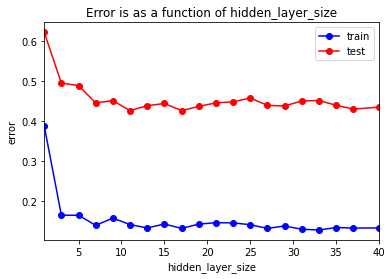

In [24]:
plt.plot(hidden_layer_size, train_err, 'b-o', label = 'train')
plt.plot(hidden_layer_size, test_err, 'r-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Error is as a function of hidden_layer_size')
plt.xlabel('hidden_layer_size')
plt.ylabel('error')
plt.legend()

print("Train: Min error={0}, number of neurons={1}".format(np.min(train_err), hidden_layer_size[np.argmin(train_err)]))
print("Test: Min error={0}, number of neurons={1}".format(np.min(test_err), hidden_layer_size[np.argmin(test_err)]))

Train: max accuracy=0.8727771966527197, number of neurons=33
Test: max accuracy=0.5737037037037037, number of neurons=11


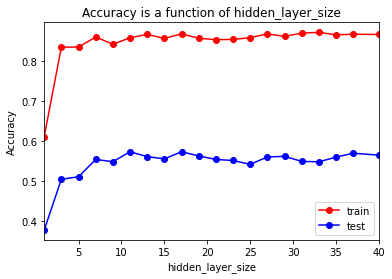

In [25]:
plt.plot(hidden_layer_size, train_acc, 'r-o', label = 'train')
plt.plot(hidden_layer_size, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Accuracy is a function of hidden_layer_size')
plt.xlabel('hidden_layer_size')
plt.ylabel('Accuracy')
plt.legend()

print("Train: max accuracy={0}, number of neurons={1}".format(np.max(train_acc), hidden_layer_size[np.argmax(train_acc)]))
print("Test: max accuracy={0}, number of neurons={1}".format(np.max(test_acc), hidden_layer_size[np.argmax(test_acc)]))

Результаты не стали лучше. В итоге так и остались с переобучением, то есть результаты выдает хорошие результаты на обучающей выборке, но имеет плохие обощающие свойства. Думаю, что причиной могли стать неинформативные признаки, недостаточное количество данных.